## Comparison of different max #nodes or max time thresholds

In [11]:
# import
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import json
import os
import pathlib

#set path to folder
folder = "../../../eval-results/_server-results/test9_1"
net_analysis = "../../../eval-results/_server-results/net-BP-birth/net.eval" 

In [41]:
#fetch data 
dir_list = next(os.walk(folder))[1]
dfs = []
#merge all 
for subfolder in dir_list:
    #print(subfolder)
    evalFile = folder +"/" + subfolder +"/aggRetrospectiveResults.eval"
    confFile = folder +"/" + subfolder +"/config.log"
    if os.path.exists(evalFile):
        df = pd.read_csv(evalFile ,encoding="ISO-8859-1", skipinitialspace=True)
        with open(confFile) as json_file:
            conf = json.load(json_file)
        #add config information to dataframe 
        df['matcher'] = conf['matcher']['ilp'] + " - " + conf['matcher']['profile'] +" - " + str(conf['matcher']['word-sim']) + " - sim-weight=" + str(conf['matcher']['sim-weight']) + " - match-postprocessing=" + str(conf['matcher']['postprocessing-thresh'] ) + " - Node Limit: " +str(conf['matcher']['ilp-node-limit']) + "- Time Limit : " +str(conf['matcher']['ilp-time-limit'])
        df['matcher_wo_weight'] = conf['matcher']['ilp'] + " - " + conf['matcher']['profile'] +" - " + str(conf['matcher']['word-sim']) + " - match-postprocessing=" + str(conf['matcher']['postprocessing-thresh']) + " - Node Limit: " +str(conf['matcher']['ilp-node-limit']) + "- Time Limit : " +str(conf['matcher']['ilp-time-limit'])
        df['matcher_wo_limit'] = conf['matcher']['ilp'] + " - " + conf['matcher']['profile'] +" - " + str(conf['matcher']['word-sim']) + " - sim-weight=" + str(conf['matcher']['sim-weight']) + " - match-postprocessing=" + str(conf['matcher']['postprocessing-thresh'] )
        df['complex-matches'] = conf['matcher']['complex matches']
        df['profile'] = conf['matcher']['profile']
        df['ilp'] =  conf['matcher']['ilp']
        df['word-sim'] =  conf['matcher']['word-sim']
        df['sim-weight'] = conf['matcher']['sim-weight']
        df['matcher-postprocessing-threshold'] = conf['matcher']['postprocessing-thresh']
        df['eval-postprocessing-threshold'] = conf['evaluation']['postprocessing-thresh']
        df['ILP-time-limit'] = conf['matcher']['ilp-time-limit']
        df['ILP-node-limit'] = conf['matcher']['ilp-node-limit']
        
        #df.set_index(['Name','matcher'])
        dfs.append(df)
        
df_combined = pd.concat(dfs)

#convert time
df_combined['OVERALL TIME'] = df_combined['OVERALL TIME'].map(lambda x: x / 1000000000.)
df_combined['BP TIME'] = df_combined['BP TIME'].map(lambda x: x / 1000000000.)
df_combined['LABEL-SIM TIME'] = df_combined['LABEL-SIM TIME'].map(lambda x: x / 1000000000.)
df_combined['LP TIME'] = df_combined['LP TIME'].map(lambda x: x / 1000000000.)

#extend with net information stored in net_analysis
df_nets = pd.read_csv(net_analysis ,encoding="ISO-8859-1", skipinitialspace=True)
#df_nets.set_index('Name')

def net1adder(row):
    #get net names
    if row['Name'] != "Aggregated (MICRO)" and row['Name'] != "Aggregated (MACRO)":
        return row['Name'].split('-')[0].replace(".pnml","")
    else:
        return 0
def net2adder(row):        
    if row['Name'] != "Aggregated (MICRO)" and row['Name'] != "Aggregated (MACRO)":
        return row['Name'].split('-')[1].split('.')[0].replace(".pnml","")
    else: 
        return 0
    
def pnml_remover(row):
    #get net names
    if row['Name'] != "Aggregated (MICRO)" and row['Name'] != "Aggregated (MACRO)":
        return row['Name'].replace(".pnml","").replace(".rdf","")
    else:
        return row['Name']

def net1NonTaus(row):
    if row['Name'] != "Aggregated (MICRO)" and row['Name'] != "Aggregated (MACRO)":
        return df_nets.at[row['net1'],'nNonSilentTransitions'] 
    else:
        return 0
def net2NonTaus(row):
    if row['Name'] != "Aggregated (MICRO)" and row['Name'] != "Aggregated (MACRO)":
        return df_nets.at[row['net2'],'nNonSilentTransitions'] 
    else:
        return 0
def sumNonTaus(row):    
    if row['Name'] != "Aggregated (MICRO)" and row['Name'] != "Aggregated (MACRO)":
        return row['net1NonTaus'] + row['net2NonTaus']
    else:
        return 0
    
df_combined['net1'] = df_combined.apply(lambda row: net1adder(row), axis=1)
df_combined['net2'] = df_combined.apply(lambda row: net2adder(row), axis=1)
df_combined['net1NonTaus'] = df_combined.apply(lambda row: net1NonTaus(row), axis=1)
df_combined['net2NonTaus'] = df_combined.apply(lambda row: net2NonTaus(row), axis=1)
df_combined['sumNonTaus'] = df_combined.apply(lambda row: sumNonTaus(row), axis=1)
df_combined['Name'] = df_combined.apply(lambda row: pnml_remover(row), axis=1)


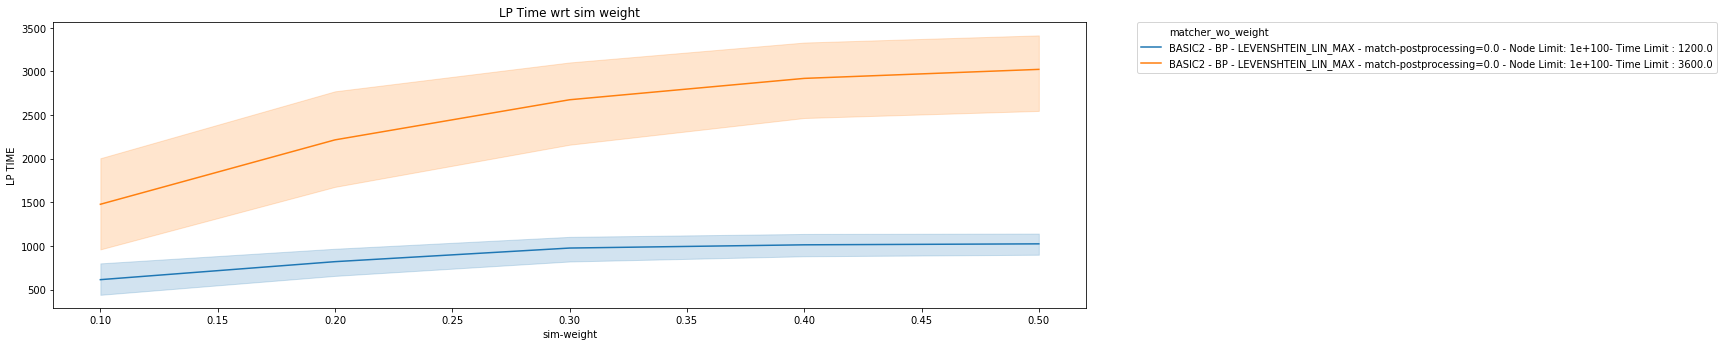

In [7]:
#time analysis

df_ = df_combined[df_combined["Name"] != "Aggregated (MICRO)"]
df_ = df_[df_["Name"] != "Aggregated (MACRO)"]

# time wrt behavioral share
fig, (ax1) = plt.subplots(1,1)
fig.set_size_inches(18.5, 5.25)
sns.lineplot(x="sim-weight", y="LP TIME", hue="matcher_wo_weight", data=df_, ax=ax1);
plt.title("LP Time wrt sim weight")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

5


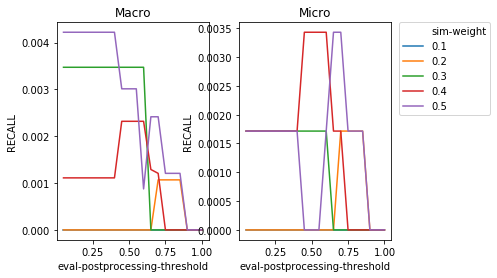

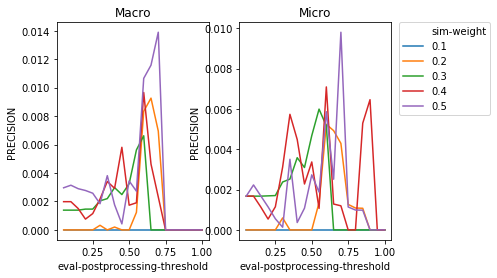

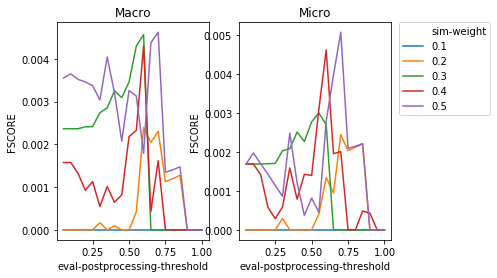

In [96]:
# results of precision recall and fscore
# we conclude the error on the result is pretty low when setting the time limit lower

# Avg Precisision Recall Fscore over postprocessing threshold
df_macro_avg = df_combined[df_combined.Name == "Aggregated (MACRO)"]
df_micro_avg = df_combined[df_combined.Name == "Aggregated (MICRO)"]


#calculate the difference between the maximum recall/precision/fscore and the minimum
#thats how we show that the reduction of time does not effect the results
df_macro_avg = df_macro_avg.groupby(['sim-weight','eval-postprocessing-threshold'])['RECALL','PRECISION','FSCORE'].agg(np.ptp)
df_macro_avg.reset_index(inplace=True)
df_micro_avg = df_micro_avg.groupby(['sim-weight','eval-postprocessing-threshold',])['RECALL','PRECISION','FSCORE'].agg(np.ptp)
df_micro_avg.reset_index(inplace=True) 

# fix a seabor bug that doesnt allow for categorical hue
diff_values = len(df_macro_avg.groupby(['sim-weight']))
df_macro_avg['sim-weight'] = df_macro_avg['sim-weight'].astype(str)
df_micro_avg['sim-weight'] = df_micro_avg['sim-weight'].astype(str)

#visualize it
fig, (ax1, ax2) = plt.subplots(1,2)
sns.lineplot(x="eval-postprocessing-threshold", y="RECALL", hue="sim-weight", data=df_macro_avg, ax = ax1,  palette=sns.color_palette(None,diff_values));
ax1.set_title("Macro")
ax1.get_legend().remove()
sns.lineplot(x="eval-postprocessing-threshold", y="RECALL", hue="sim-weight", data=df_micro_avg, ax = ax2,  palette = sns.color_palette(None,diff_values));
ax2.set_title("Micro")
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

fig, (ax1, ax2) = plt.subplots(1,2)
sns.lineplot(x="eval-postprocessing-threshold", y="PRECISION", hue="sim-weight", data=df_macro_avg, ax = ax1, palette= sns.color_palette(None,diff_values));
ax1.set_title("Macro")
ax1.get_legend().remove()
sns.lineplot(x="eval-postprocessing-threshold", y="PRECISION", hue="sim-weight", data=df_micro_avg, ax = ax2, palette= sns.color_palette(None,diff_values));
ax2.set_title("Micro")
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

fig, (ax1, ax2) = plt.subplots(1,2)
sns.lineplot(x="eval-postprocessing-threshold", y="FSCORE", hue="sim-weight", data=df_macro_avg, ax = ax1, palette= sns.color_palette(None,diff_values));
ax1.set_title("Macro")
ax1.get_legend().remove()
sns.lineplot(x="eval-postprocessing-threshold", y="FSCORE", hue="sim-weight", data=df_micro_avg, ax = ax2, palette= sns.color_palette(None,diff_values));
ax2.set_title("Micro")
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [127]:
#only regard neeeded part
delete = True
file = "../../../eval-results/_server-results/gurobi-logs/test.log"
cleaned = "cleaned.log"
infile = open(file,'r').readlines()
with open(cleaned,'w') as outfile:
    for index,line in enumerate(infile):
        if "Cutting plane" in line:
            delete = True
        if " Expl" in line and "It/Node Time" in line:
            delete = False
        line = line.replace('H','').replace('s','').replace('|.1','').replace('|.2','').replace('|','')
        if not delete:
            outfile.write(line)
            

#read table
gurobi_df =pd.read_csv(cleaned, delim_whitespace=True)

gurobi_df


,Expl,Unexpl,Obj,Depth,IntInf,Incumbent,BetBd,Gap,It/Node,Time
0,0,0,0.708150,0.00000,235,0.36010,0.70815,96.7%,-,5.0
1,0,0,0.512862,0.70815,38.1%,-,5.00000,NaN,NaN,NaN
2,0,0,0.523315,0.70815,35.3%,-,5.00000,NaN,NaN,NaN
3,0,0,0.556176,0.70815,27.3%,-,11.00000,NaN,NaN,NaN
4,0,0,0.557726,0.70815,27.0%,-,16.00000,NaN,NaN,NaN
5,0,0,0.558183,0.70815,26.9%,-,16.00000,NaN,NaN,NaN
6,0,0,0.708150,0.00000,235,0.55818,0.70815,26.9%,-,18.0
7,0,0,0.562809,0.70815,25.8%,-,34.00000,NaN,NaN,NaN
8,0,0,0.568139,0.70815,24.6%,-,34.00000,NaN,NaN,NaN
9,0,0,0.571707,0.70815,23.9%,-,43.00000,NaN,NaN,NaN
